# Experimento 4

Hacemos cross-validation dejando uno afuera, usando el algoritmo de machine learning para crear la matris de submuestreo y el algoritmo de optimizacion para reconstruir la imagen con alta resolucion

In [1]:
%pylab inline
import time
import numpy as np
import cvxpy as cvx
import matplotlib.pyplot as plt
from utils import img_utils
import seaborn as sns
import utils.math_utils as mu
import nibabel as nib
from dipy.core.gradients import gradient_table
reload(img_utils)


Populating the interactive namespace from numpy and matplotlib


<module 'utils.img_utils' from 'utils/img_utils.pyc'>

## Load DWI

In [2]:
from utils.DataGetter import DataGetter
from utils.DownsampledImage import DownsampledImage

d = DataGetter()
datas_names = [
    DataGetter.STANDFORD_HARDI_DATA, #(81, 106, 76, 160)
    #DataGetter.TAIWAN_NTU_DSI_DATA,  #(96, 96, 60, 203)
    #DataGetter.SHERBROOKE_3SHELL_DATA #(128, 128, 60, 193)
]

scale=2
datas = d.get_data(datas_names)
name = datas_names[0]
gtab = datas[name]['gtab']

lr_hr_img = DownsampledImage(name, datas[name]['img'], gtab, scale)

img_hr = lr_hr_img.get_hr_img().astype(float)
img_lr = lr_hr_img.get_lr_img().astype(float)

/user/lgomez/home/anaconda2/lib/python2.7/site-packages/skimage/filter/__init__.py:6: skimage_deprecation: The `skimage.filter` module has been renamed to `skimage.filters`.  This placeholder module will be removed in v0.13.
  warn(skimage_deprecation('The `skimage.filter` module has been renamed '


Dataset is already in place. If you want to fetch it again please first remove the folder /user/lgomez/home/.dipy/stanford_hardi 
Dataset is already in place. If you want to fetch it again please first remove the folder /user/lgomez/home/.dipy/stanford_hardi 


## Select VOI


In [17]:
img_shape = img_lr.shape
x0,xf, y0,yf, z0,zf = volume_range_lr = (22, 28, 15, 21, 23, 29)
b0, bf = bval_range = (10,16)
gdirections = lr_hr_img.gtab.bvecs[b0:bf]

# Type and intensiti of noise to apply
SNR, SNR_TYPE = 25, 'gaussian'

#img_hr[2*x0:2*xf, 2*y0:2*yf, 2*z0:2*zf, b0:bf] = (img_hr[2*x0:2*xf, y0, 2*z0:2*zf, b0:bf].max())*np.ones((12,12,12,6))

i_lr = img_lr[x0:xf, y0:yf, z0:zf, b0:bf]
i_hr = img_hr[2*x0:2*xf, 2*y0:2*yf, 2*z0:2*zf, b0:bf]
voi_hr_shape = i_hr.shape
voi_lr_shape = i_lr.shape

## Save VOI selected

In [ ]:
## Save i_hr ##
RES_BASE_FOLDER = './resultados/exp4/'
np.save(RES_BASE_FOLDER+'i_hr', i_hr)
np.save(RES_BASE_FOLDER+'i_lr', i_lr)

('b=2000, G directions =',
 array([[  2.18280000e-02,   8.02420000e-01,  -5.96360000e-01],
        [ -1.54250000e-02,   2.20980000e-01,   9.75160000e-01],
        [ -7.09180000e-01,  -6.31060000e-04,  -7.05030000e-01],
        [ -2.46500000e-01,   1.04300000e-01,  -9.63510000e-01],
        [ -4.83470000e-01,   4.39100000e-01,  -7.57260000e-01],
        [  1.51030000e-01,   9.65230000e-01,   2.13360000e-01]]))

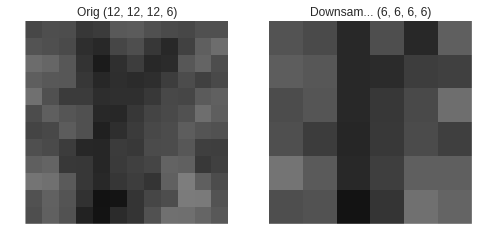

In [4]:
# Show VOI
img_utils._isc(i_hr,i_lr,titles=['Orig '+ str(i_hr.shape), 'Downsam... '+str(i_lr.shape)] )
'b=2000, G directions =', gdirections

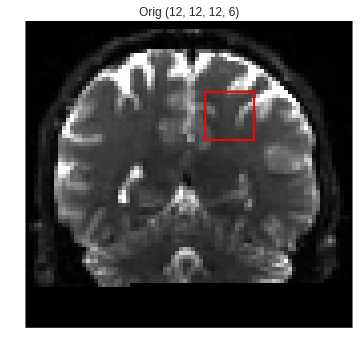

(81, 12, 76) y= 6
HR max,min 989.0 56.3402134135 79.521167049


In [5]:
## Show VOI in HR context
rect_hr = 2*z0, 2*x0, 2*xf-2*x0, 2*zf-2*z0

res=img_utils._iswr(img_hr[:,2*y0:2*yf,:,0],  rect_hr, b=1,title='Orig '+ str(i_hr.shape), vmax=2500)
## For save in fs
# res[1].savefig('/user/lgomez/home/Documents/tesis/optimizacion/img/hardi.pdf')
print 'HR max,min', img_hr[:,:,:,10:16].max(), img_hr[:,:,:,10:16].mean(), np.std(img_hr[:,:,:,10:16])

In [ ]:
## Show VOI in LR context
rect_lr = z0, x0, xf-x0, zf-z0

res =img_utils._iswr(img_lr[:,y0:yf,:,0], rect_lr,b=1, title='Sub muestro '+str(i_lr.shape), vmax=2500)
## For save in fs
# res[1].savefig('/user/lgomez/home/Documents/tesis/optimizacion/img/downsampling.pdf')
print 'LR max,min', img_lr.min(), img_lr.max()
print rect_lr

# Predicting the G downsampling Matrix

## Training set generator

In [4]:
def load_subject(index, numbers, bval=None, bvalpos=None ):
    subject = str(numbers[index])
    folder = './HCP/'+subject+'/'
    bvals = np.loadtxt(folder+ 'bvals_'+subject)
    bvecs = np.loadtxt(folder+'bvecs_'+subject)
    
    if bvalpos is not None:
        img = nib.load(folder+ 'data_small_12x12x12x6_'+subject+'_b'+str(bval)+'.nii.gz')
        gtab = gradient_table(bvals=bvals[bvalpos], bvecs=bvecs[:,bvalpos])
    else:
        img = nib.load(folder+ 'data_small_12x12x12x6_'+subject+'.nii.gz')
        gtab = gradient_table(bvals=bvals, bvecs=bvecs)
    return img, gtab

def get_sample(index, numbers, bval=None, bvalpos=None,  scale=2):
    img, gtab = load_subject(index, numbers, bval, bvalpos)
    lr, lr_affine = img_utils.downsampling(img, scale)
    return img.get_data(), lr

def get_sample_maker(numbers, bval=None, bvalpos=None, scale=2):
    return lambda index : get_sample(index, numbers, bval, bvalpos,  scale)

def mm(A):
    return (A.min(), A.max())
    
def buildT(sample_getter, n_samples):
    noised_hr, noised_lr = sample_getter(0)
    X = img_utils.column_this(noised_lr)
    Y = img_utils.column_this(noised_hr)
    for i in range(1, n_samples):
        noised_hr, noised_lr = sample_getter(i)
        X = img_utils.append_column(X, noised_lr)
        Y = img_utils.append_column(Y, noised_hr)
    return X, Y

## Example of use
#buildT(get_sample_maker(numbers, scale), n_samples)

## Problem definition

$ \min_{Y_{hr}} \{ ||GY_{lr} - Y_{hr}||^2 \}$ st $Y_{hr} \geq 0$

In [46]:

def define_problem(i_lr, i_hr_shape, downsampling_matrix, scale):
    Nx, Ny, Nz, bval = i_hr_shape
    vhrb = Nx*Ny*Nz*bval
    vlr = Nx*Ny*Nz/(scale**3)
      
    Yhr = cvx.Variable(vhrb, 1)
    #Yhr.value = np.ones((vhrb, 1))*i_lr.mean()
    
    Ylr = cvx.Parameter(vlr*bval, 1, sign="positive")
    Ylr.value = i_lr.reshape((vlr*bval, 1), order='F')
    
    G = cvx.Parameter(vlr*bval, vhrb)
    G.value = downsampling_matrix

    # Form objective.
    obj = cvx.Minimize(cvx.sum_squares(G*Yhr - Ylr))

    # Create two constraints.
    #constraints = [Yhr >= 0]

    # Form and solve problem.
    prob = cvx.Problem(obj)
    return prob, Yhr, Ylr, G


def define_problem_with_tv(i_lr, i_hr_shape, downsampling_matrix, scale):
    Nx, Ny, Nz, bval = i_hr_shape
    nx, ny, nz = Nx/scale, Ny/scale, Nz/scale
    vhr = Nx*Ny*Nz
    vhrb = vhr*bval
    vlr = nx*ny*nz
      
    Yhr = cvx.Variable(vhrb, 1)
    Yhr.value = np.ones((vhrb, 1))*i_lr.mean()
    
    Ylr = cvx.Parameter(vlr*bval, 1, sign="positive")
    Ylr.value = i_lr.reshape((vlr*bval, 1), order='F')
    
    G = cvx.Parameter(vlr*bval, vhrb)
    G.value = downsampling_matrix
    
    
    # Hacer tiras de imagenes por cada b_val
    Yhr_b = cvx.reshape(Yhr, Nx*Ny*Nz, bval)
    slices_xy = []
    for b in xrange(bval):
        slices_xy_b = []
        pp = cvx.reshape(Yhr_b[:,b], Nx, Ny*Nz)
        for z in xrange(Nz):
            ppz = pp[:, z*Nz:(z+1)*Nz]
            ppp = cvx.reshape(ppz, Nx, Ny)
            slices_xy_b.append(ppp)
        slices_xy.append(slices_xy_b)
    
    big_img = cvx.bmat(slices_xy)
    print 'BMAT SIZE= ', big_img.size
    tv_norm = cvx.tv(big_img)
    # ESTA ANDA BASTANTE FEO
    #tv_norm = cvx.tv(cvx.reshape(cvx.reshape(Yhr, 12*12*12, 6), 12,12*12*6))
    
    
    #PROBAR ESTE-->
    #tv_norm = cvx.tv(cvx.reshape(Yhr, 12,12*12*6))
    
   
    gamma = cvx.Parameter(sign="positive")
    gamma.value = 1
    #tv_norm = cvx.tv(cvx.reshape(Yhr, Nx, Nz*Ny*bval))
        
    #mu = i_lr.mean()
    #std = np.std(i_lr)    
    
    #constraints = [Yhr >= 0, mu == cvx.sum_entries(Yhr)/vhrb, var == cvx.sum_squares(Yhr-mu)]
    constraints = [Yhr >= 0 ]
    
    # Form objective.
    obj = cvx.Minimize(cvx.sum_squares(G*Yhr - Ylr) + gamma*tv_norm )
    
    # Form and solve problem.
    prob = cvx.Problem(obj, constraints)
    return prob, Yhr, Ylr, G

'1,2,3'

## Solving the problem and cross-validation (leave one out)

In [47]:
def solveMin(i_lr, i_hr_shape, downsampling_matrix, scale=2, max_iters=1500, verbose=False):
    #prob, Yhr, Ylr, G = define_problem(i_lr, i_hr_shape, downsampling_matrix, scale)
    prob, Yhr, Ylr, G = define_problem_with_tv(i_lr, i_hr_shape, downsampling_matrix, scale)
    
    start_time = time.time()
    res = prob.solve(solver='SCS', max_iters=max_iters, eps=1.00e-01, verbose=verbose )  # Returns the optimal value.
    #res = prob.solve(solver='ECOS', verbose=verbose )  # Returns the optimal value.
    """
        'max_iters'
            maximum number of iterations (default: 100).
        'abstol'
            absolute accuracy (default: 1e-7).
        'reltol'
            relative accuracy (default: 1e-6).
        'feastol'
            tolerance for feasibility conditions (default: 1e-7).
        'abstol_inacc'
            absolute accuracy for inaccurate solution (default: 5e-5).
        'reltol_inacc'
            relative accuracy for inaccurate solution (default: 5e-5).
        'feastol_inacc'
            tolerance for feasibility condition for inaccurate solution (default: 1e-4). 
    """
    
    seg = time.time() - start_time

    minutes = int(seg / 60)
    print("--- time of optimization : %d' %d'' ---" % (minutes , seg%60))
    print "--- status:", prob.status, "optimal value", prob.value
    print 

    # Change dimension of result representation
    if Yhr.value is None :
        #Yhr.value = np.ones(i_hr_shape)
        print 'FRECONSTRUCTION FAIL :('
        A = np.zeros(i_hr_shape,dtype='float32')
    else:    
        A = np.asarray(Yhr.value, dtype='float32').reshape(i_hr_shape, order='F')
        
    return A, seg, prob


== Leaving out: # 180937
SAMPLES min/max  29.1264362335 2830.05957031 12.4889230728 3112.2512207
= Training and fiting ...
= Solving optimization problem ...
BMAT SIZE=  (72, 144)
----------------------------------------------------------------------------
	SCS v1.2.6 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2016
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 13498063, CG tol ~ 1/iter^(2.00)
eps = 1.00e-01, alpha = 1.50, max_iters = 1500, normalize = 1, scale = 1.00
Variables n = 20522, constraints m = 42125
Cones:	linear vars: 10368
	soc vars: 31757, soc blks: 10154
Setup time: 7.39e-01s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0|      inf       inf      -nan      -inf       inf       inf  1.0

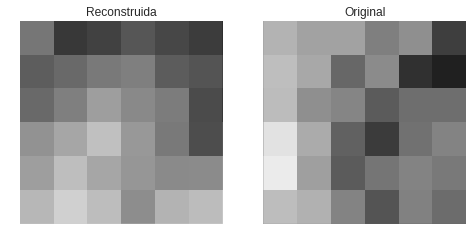

In [48]:
from scipy.sparse import csr_matrix
import experimento1_funciones as e1f
reload(img_utils)

RES_BASE_FOLDER = './resultados/exp4/'
VMIN, VMAX=-50, 2500

voi_hr_shape = (12, 12, 12, 6)
voi_lr_shape = (6, 6, 6, 6)
subjects = [100307, 100408, 180129, 180432, 180836, 180937]
bvals2000pos = [18, 27, 69, 75, 101, 107]
sample_maker = get_sample_maker(subjects, bval=2000, bvalpos=bvals2000pos, scale=2)

n_samples = 6
iterations = 6

# Metrics to save
min_vals_hr_r = []
max_vals_hr_r = []
min_vals_lr_r = []
max_vals_lr_r = []

dif_norm_hrs=[]
dif_norm_lrs=[]    
Yhr_recons_norms=[]
Ylr_recons_norms=[]  
Yhr_norms=[]
Ylr_norms=[]
times = []
optimal_vals = []

base_folder = RES_BASE_FOLDER
#base_folder = None

for i in range(0, iterations):
    subject = str(subjects[len(subjects)-1])
    print '== Leaving out: #', subject
    
    ### Aca shiftear el arreglo de sujetos (train deja el ultimo afuera del entrenamiento)
    subjects.append(subjects.pop(0))
    lr_samples, hr_samples = buildT(sample_maker, n_samples) #lr, hr

    #lr_samples, hr_samples = lr_samples/1589, hr_samples/1589
    print 'SAMPLES min/max ', lr_samples.min(),lr_samples.max(),  hr_samples.min(), hr_samples.max()
    
    # Build downsampling matrix
    print '= Training and fiting ...'
    regr, hr_train , lr_train, hr_test, lr_test = e1f.train(hr_samples, lr_samples)
    regr.coef_ = csr_matrix(regr.coef_)
    
    # Reshape the one that left out to validate
    i_lr = lr_test.reshape(voi_lr_shape, order='F')
    i_hr = hr_test.reshape(voi_hr_shape, order='F')
    
    # Minimization solve
    # mock: A, seg = np.ones(i_hr.shape), 20
    print '= Solving optimization problem ...'
    A, seg, prob = solveMin(i_lr, i_hr.shape, regr.coef_, scale=2, max_iters=1500, verbose=True)
    max_vals_hr_r.append(A.max())
    min_vals_hr_r.append(A.min())
    
    B = (regr.coef_*i_hr.reshape(-1, order='F')).reshape(voi_lr_shape, order='F')
    max_vals_lr_r.append(B.max())
    min_vals_lr_r.append(B.min())
    
    # Keep parameters
    print '= Calculating metrics...'
    dif_norm_hr = np.linalg.norm(i_hr-A) # recons-gtrust
    Yhr_norm = np.linalg.norm(i_hr)
    Yhr_recons_norm = np.linalg.norm(A) #recons
    
    dif_norm_lr = np.linalg.norm(i_lr-B)
    Ylr_norm = np.linalg.norm(B)
    Ylr_recons_norm = np.linalg.norm(B)
    
    dif_norm_hrs.append(dif_norm_hr)
    dif_norm_lrs.append(dif_norm_lr)
    
    Yhr_recons_norms.append(Yhr_recons_norm)
    Ylr_recons_norms.append(Ylr_recons_norm)
    
    Yhr_norms.append(Yhr_norm)
    Ylr_norms.append(Ylr_norm)
    
    times.append(seg)
    optimal_vals.append(prob.value)

    # Save the A calculated
    if base_folder is not None:
        name = base_folder+ "A/" + 'hrRec_lo' + subject
        np.save(name, A)
        print 'showing hr '+ subject, 'min, max',(A.min(), A.max()) 
        titles=['Reconstruida', 'Original']
        for b in xrange(6):
            plt = img_utils._isc(A, i_hr,b=b ,titles=titles,  vmax=VMAX, vmin=VMIN)
            plt.savefig(name +'b'+str(b)+'.pdf')
        print 'saved A in: ', name + str('.npy')
        
    # Save the B calculated
    if base_folder is not None:
        name = base_folder + 'lrRec_lo' + subject
        np.save(name, B)
        print 'showing lr '+ subject, 'min, max',(B.min(), B.max()) 
        titles=['Reconstruida', 'Original']
        plt = img_utils._isc(B, i_lr, titles=titles,  vmax=VMAX, vmin=VMIN)
        plt.savefig(name + '.pdf')
        print 'saved A in: ', name + str('.npy')
        
    print
    print

# Log spended
total_sec = np.array(times).sum()
print ' === TOTAL TIME :',  str(int(total_sec//60))+"'", str(int(total_sec%60))+ '"'

# Persist results
if base_folder is not None: 
    np.save(base_folder+ 'dif_norm_hrs', dif_norm_hrs)
    np.save(base_folder+ 'dif_norm_lrs', dif_norm_lrs)
    np.save(base_folder+ 'Yhr_recons_norms', Yhr_recons_norms)
    np.save(base_folder+ 'Ylr_recons_norms', dif_norm_hrs)
    np.save(base_folder+ 'Yhr_norms', dif_norm_lrs)
    np.save(base_folder+ 'Ylr_norms', Yhr_recons_norms)
    
    np.save(base_folder+ 'max_vals_hr_r', max_vals_hr_r)
    np.save(base_folder+ 'min_vals_hr_r', min_vals_hr_r)
    np.save(base_folder+ 'max_vals_lr_r', max_vals_hr_r)
    np.save(base_folder+ 'min_vals_lr_r', min_vals_hr_r)
    
    np.save(base_folder+ 'times' , times)
    np.save(base_folder+ 'optimal_vals', optimal_vals)


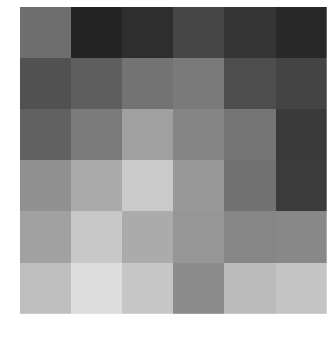

In [122]:
B = (regr.coef_*i_hr.reshape(-1, order='F')).reshape(voi_lr_shape, order='F')
img_utils._is(B, vmin=230, vmax=2291)
B.min(), B.max()

In [119]:
print lr_samples.min(),lr_samples.max(), hr_samples.min(), hr_samples.max()
#A = np.asarray(Yhr.value, dtype='float64').reshape(i_hr.shape)
#img_utils._isc(A, i_hr,b=5, vmin=0, vmax=1994 )

#img_utils._is(i_hr, vmax=1864)
print 'recons', (A.min(), A.mean(), np.std(A), A.max())
print 'orig',(i_hr.min(), i_hr.mean(),np.std(i_hr), i_hr.max())
#G.shape

print 'primera forma de tvnorm reshape(Yhr, Nx*Ny*Nz, bval)'
print 'dif_norm_hrs', np.array(dif_norm_hrs).mean(), np.std(dif_norm_hrs) 
print 'dif_norm_lrs', dif_norm_lrs   
print 'Yhr_recons_norms', Yhr_recons_norms
print 'Ylr_recons_norms', Ylr_recons_norms
print 'Yhr_norms', Yhr_norms
print 'Ylr_norms', Ylr_norms
print 'times',times
print 'optimal_vals', optimal_vals
min_vals_hr_r

29.1264362335 2830.05957031 12.4889230728 3112.2512207
recons (-44.974922, 1134.6599, 577.12354, 2190.9661)
orig (25.37767219543457, 1150.8383932880781, 430.85226519074263, 2805.781494140625)
primera forma de tvnorm reshape(Yhr, Nx*Ny*Nz, bval)
dif_norm_hrs 48974.2251814 12775.3776332
dif_norm_lrs [10381.806480237039, 15904.202550468717, 14689.002104720963, 9610.8219554376974, 10753.442791509822, 17646.047504724036]
Yhr_recons_norms [93086.82, 95644.469, 114271.49, 94329.453, 73344.055, 129620.98]
Ylr_recons_norms [30867.538619137689, 33463.672033452618, 37572.704347895451, 31884.597320442364, 22783.488479764248, 42209.155273016899]
Yhr_norms [87069.886863060499, 100953.90684595105, 107565.35798833604, 89007.294479625343, 66721.119861131345, 125125.25678612119]
Ylr_norms [30867.538619137689, 33463.672033452618, 37572.704347895451, 31884.597320442364, 22783.488479764248, 42209.155273016899]
times [22.305898189544678, 29.32785391807556, 22.55314302444458, 21.77543807029724, 29.6348018646

[-35.673389, 0.18885134, -53.420452, -25.665865, -7.5632515, -44.974922]

recons (-47.653938, 820.35303, 2884.0952)
orig (25.006494522094727, 773.02679759907869, 2397.716064453125)
con la primer forma de tvnorm
dif_norm_hrs [77578.886804409049]
dif_norm_lrs [12435.942451585284]
Yhr_recons_norms [113267.64]
Ylr_recons_norms [30770.610425770086]
Yhr_norms [89007.294479625343]
Ylr_norms [30770.610425770086]
times [28.458673000335693]
optimal_vals [653517.1243061691]


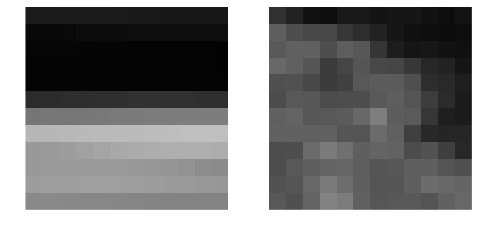

In [108]:
img_utils._isc(A, i_hr,b=5, vmax=max(i_hr.max(), A.max()), vmin=min(i_hr.min(),A.min()))

#img_utils._is(A, vmin=A.min(), vmax=A.max())
print 'recons', (A.min(), A.mean(), A.max())
print 'orig',(i_hr.min(), i_hr.mean(), i_hr.max())
#G.shape

print 'con la primer forma de tvnorm'
print 'dif_norm_hrs', dif_norm_hrs
print 'dif_norm_lrs', dif_norm_lrs   
print 'Yhr_recons_norms', Yhr_recons_norms
print 'Ylr_recons_norms', Ylr_recons_norms
print 'Yhr_norms', Yhr_norms
print 'Ylr_norms', Ylr_norms
print 'times',times
print 'optimal_vals', optimal_vals

<module 'matplotlib.pyplot' from '/user/lgomez/home/anaconda2/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

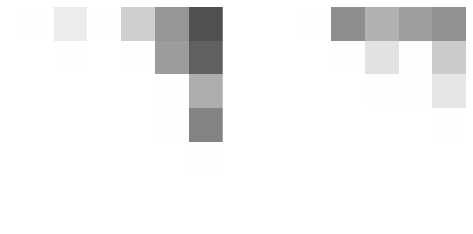

In [91]:
B = (regr.coef_*i_hr.reshape(-1, order='F')).reshape(voi_lr_shape, order='F')
img_utils._isc(i_lr, B)

(1296, 10368) (12, 12, 12, 6)


((6, 6, 6), 1174.9864601500353, 47.22263127414044, 2264.5927734375)

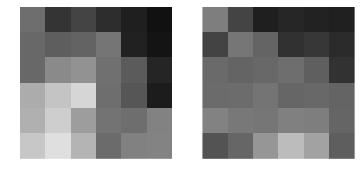

In [142]:
print regr.coef_.shape, i_hr.shape
i_lr_fake = (regr.coef_*i_hr.reshape(-1)).reshape(voi_lr_shape)
dif_lr = (regr.coef_*i_hr.reshape(-1)-regr.coef_*A.reshape(-1)).reshape(voi_lr_shape)
mse_lr = (dif_lr**2).mean(axis=3) 
img_utils._isc(i_lr, i_lr_fake, vmax=i_lr.max())
mse_lr.shape, mse_lr.max(), dif_lr.max(), i_lr.max()

(array([ 13.,  16.,  10.,  13.,  11.,  41.,  21.,  11.,   4.,   4.]),
 array([  168.4126624 ,   309.15789776,   449.90313311,   590.64836846,
          731.39360381,   872.13883917,  1012.88407452,  1153.62930987,
         1294.37454523,  1435.11978058,  1575.86501593]),
 <a list of 10 Patch objects>)

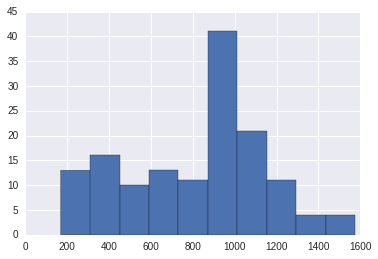

In [119]:
hist(B[:,6,:,0].flatten())

(array([ 21.,  18.,  13.,  16.,  27.,  21.,   7.,  10.,   7.,   4.]),
 array([   83.05593109,   291.92477646,   500.79362183,   709.66246719,
          918.53131256,  1127.40015793,  1336.2690033 ,  1545.13784866,
         1754.00669403,  1962.8755394 ,  2171.74438477]),
 <a list of 10 Patch objects>)

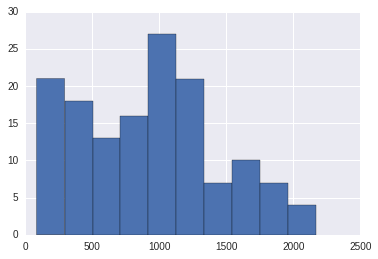

In [120]:
hist(i_hr[:,6,:,0].flatten())

1589.5722161036583

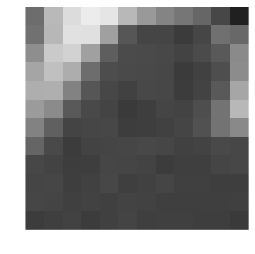

In [53]:
img_utils._is(hr_samples[:,0].reshape(voi_hr_shape), vmax=hr_samples[:,0].max())
hr_samples.mean()

In [95]:

bvals = gtab.bvals
a2000=[]
a5=[]
a2000_acum=set()
a5_acum=set()
for s in [100307, 100408, 180129, 180432, 180836, 180937]:
    img, gtab =load_subject(0,[s])
    a5=[]
    a2000=[]
    for i in range(0, bvals.size):
        if bvals[i] == 2000 : a2000.append(i)
        if bvals[i] == 5 : a5.append(i)
            
    #print a2000
    if s == 100307:
        a2000_acum= set(a2000)
        a5_acum = set(a5)
    else:
        a2000_acum= a2000_acum.intersection(set(a2000))
        a5_acum =a5_acum.intersection(set(a5))

        
print sort(list(a2000_acum))
print sort(list(a5_acum))
print bvals

print bvals[list(a2000_acum)]

[  2  18  27  69  75 101 107 126 146 152 166 216 229 236 248 264 284 286]
[  0  16  32  48  64  80  95 112 128 144 160 176 191 208 224 240 256 272]
[    5.  1000.  2000.  3005.   995.  2995.  2005.   990.  1990.  2995.
  1000.  1990.  2990.  1005.  1995.  2995.     5.   995.  2000.  3010.
  3005.   995.  2010.   995.  1990.  2985.  1000.  2000.  3005.   995.
  1995.  2985.     5.  3005.   995.  2005.   990.  1985.  2990.   995.
  2985.  1995.  3005.   995.  2005.  1000.  1990.  2995.     5.  1005.
  2005.  2995.  2995.  1005.  1985.  1005.  2990.  2005.   995.  1990.
  3005.   995.  2990.  1995.     5.   990.  2005.  3000.  1000.  2000.
  3000.   995.  2005.  3005.  1000.  2000.  3010.   990.  2005.  1995.
     5.  1000.  3010.  2985.  1005.  1995.  3000.  1000.  2005.  3000.
   990.  2005.  2990.  3000.  1000.     5.  2995.  1000.  1995.  1995.
  1005.  2000.  2995.  1000.  2010.  2995.  1005.  2000.  3010.  1000.
  2005.  2990.     5.   995.  2985.  2005.  1000.  2005.  2985.   995.


In [108]:
bvals2000pos = [18,27,69,75,101, 107]
bvals5pos = [0,16,32,48,64,80]

img2000, gtab2000 = load_subject(0, [100307, 100408, 180129, 180432, 180836, 180937], bval=2000, bvalpos=bvals2000pos)
print gtab2000.bvals

img5, gtab5 = load_subject(0, [100307, 100408, 180129, 180432, 180836, 180937], bval=2000, bvalpos=bvals5pos)
print gtab5.bvals


[ 2000.  2000.  2000.  2000.  2000.  2000.]
[ 5.  5.  5.  5.  5.  5.]


In [44]:
print type(Yhr.value), prob.status,

A = np.asarray(Yhr.value, dtype='float64').reshape(i_hr.shape)


 <type 'NoneType'> infeasible

ValueError: total size of new array must be unchanged

In [48]:
max_vals_lr_r, min_vals_lr_r

([1777.7107171056055, 1772.8766956070024],
 [136.08327762918259, 184.04265327716803])

In [125]:
i_hr.shape, 12*12*12*6
base_folder=None

# Mean and standar desviation of the cross validation

In [ ]:
print "Yhr_norms"
print Yhr_norms, np.array(Yhr_norms).mean(), '+/-', np.std(Yhr_norms)

print "Ylr_norms"
print Ylr_norms, np.array(Ylr_norms).mean(), '+/-', np.std(Ylr_norms)

print "dif_norms"
print dif_norms, np.array(dif_norms).mean(), '+/-', np.std(dif_norms)

print "optimal_vals"
print optimal_vals, np.array(optimal_vals).mean(), '+/-', np.std(optimal_vals)

print "times"
print times, np.array(times).mean(), '+/-', np.std(times)


In [141]:
reload(img_utils)

<module 'utils.img_utils' from 'utils/img_utils.py'>

BMAT SIZE=  (72, 144)
(12, 12)


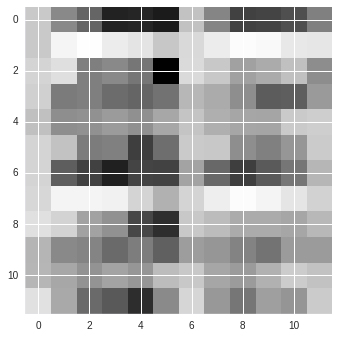

In [38]:
Nx, Ny, Nz, bval = i_hr.shape
vhrb = Nx*Ny*Nz*bval

Yhr_fake = cvx.Variable(vhrb, 1)
Yhr_fake.value = i_hr.reshape((vhrb, 1))
    
# Hacer tiras de imagenes por cada b_val
Yhr_fake_b = cvx.reshape(Yhr_fake, Nx*Ny*Nz, bval)
slices_xy = []
for b in xrange(bval):
    slices_xy_b = []
    pp = cvx.reshape(Yhr_fake_b[:,b], Nx, Ny*Nz)
    for z in xrange(Nz):
        ppz = pp[:, z*Nz:(z+1)*Nz]
        ppp = cvx.reshape(ppz, Nx, Ny)
        slices_xy_b.append(ppp)
    slices_xy.append(slices_xy_b)

big_img = cvx.bmat(slices_xy)
print 'BMAT SIZE= ', big_img.size
A = np.asarray(big_img.value, dtype='float32')#.reshape(i_hr.shape, order='F')
        
P1= np.asarray(slices_xy[0][0].value,dtype='float32')
print P1.shape
imshow(P1[:12,:12], interpolation='none')
#img_utils._is(A, vmin=VMIN, vmax=VMAX)

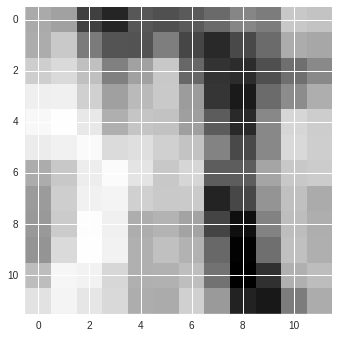

In [41]:
imshow(i_hr[0:12,0:12,0,0], interpolation='none')

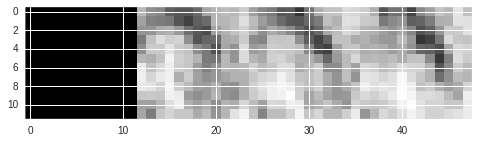

In [70]:
i_hr2=np.copy(i_hr)
i_hr2[:, :, 0, 0]=np.ones((Nx, Ny))*i_hr2.max()

Nx, Ny, Nz, bval = voi_hr_shape
vhr = Nx*Ny*Nz

Yhr = cvx.Parameter(vhr*bval, 1)
Yhr.value = i_hr2.reshape(-1, order='F')#(vhr*bval, 1)

rS = cvx.reshape(Yhr, Nx, Nz*Ny*bval)

#rSS = [cvx.reshape(rS[:, b], Nx, Ny*Nz) for b in xrange(bval)]

LR = np.asarray(rS.value, dtype='float32')#.reshape(voi_hr_shape)
imshow(LR[:24,:48],interpolation='none')
#print i_hr.shape
#imshow(i_hr2.reshape(-1, order='F').T.reshape((Nx*Nz, Ny*bval), order='F')[:24, :], interpolation='none')

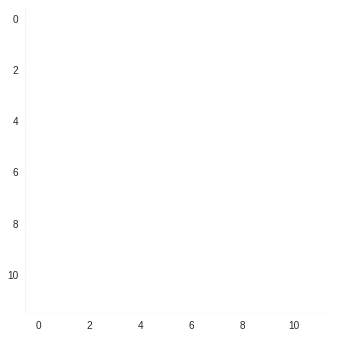

In [96]:
i_hr2[:, 0, :, 0] = np.zeros((Nx, Nz))
imshow(i_hr2[:,0, :, 0], interpolation='none')

In [49]:

def indices4(shape):
    nx, ny, nz, nb = shape
    charar = np.zeros(shape, dtype=int)
    for x in xrange(nx):
        for y in xrange(ny):
            for z in xrange(nz):
                for b in xrange(nb):
                    charar[x,y,z,b] = int(''.join(['-1',str(x),str(y),str(z),str(b)]))
    return charar
        

prob, Yhr, Ylr, G = define_problem(i_lr, i_hr.shape, regr.coef_, 2)

#prob, Yhr, Ylr, G, mm(regr.coef_)
I = indices4((12,12,12,6))

Icv = cvx.Variable(I.size)
Icv.value = I.reshape(I.size, order='F')

P = cvx.reshape(Icv, 12*12*12, 6)

fetas = []
for b in xrange(6):
    pb = P[:,b]
    pp = cvx.reshape(pb, 12, 12*12)
    for z in xrange(12):
        ppz = pp[:, z*12:(z+1)*12]
        ppp = cvx.reshape(ppz, 12, 12)
        fetas.append(ppp)
        #print ppp.size, b, z
print 'tot', len(fetas)        
        

#PP = [P[:,b] for b in xrange(6)]
#P0 = PP[0]
#PPP0 = cvx.reshape(P0, 12, 12*12)
#PPPP = cvx.reshape(PPP0[:, 0:12], 12, 12)
#print PPPP.size
#PPPP.value[0:15, 10:12]
print fetas[0][:,0:7].value

tot 72
[[ -10000.  -10100.  -10200.  -10300.  -10400.  -10500.  -10600.]
 [ -11000.  -11100.  -11200.  -11300.  -11400.  -11500.  -11600.]
 [ -12000.  -12100.  -12200.  -12300.  -12400.  -12500.  -12600.]
 [ -13000.  -13100.  -13200.  -13300.  -13400.  -13500.  -13600.]
 [ -14000.  -14100.  -14200.  -14300.  -14400.  -14500.  -14600.]
 [ -15000.  -15100.  -15200.  -15300.  -15400.  -15500.  -15600.]
 [ -16000.  -16100.  -16200.  -16300.  -16400.  -16500.  -16600.]
 [ -17000.  -17100.  -17200.  -17300.  -17400.  -17500.  -17600.]
 [ -18000.  -18100.  -18200.  -18300.  -18400.  -18500.  -18600.]
 [ -19000.  -19100.  -19200.  -19300.  -19400.  -19500.  -19600.]
 [-110000. -110100. -110200. -110300. -110400. -110500. -110600.]
 [-111000. -111100. -111200. -111300. -111400. -111500. -111600.]]


In [101]:
vhr = 12*12*12
vhrb = vhr*6
make_ix = lambda i : [i, i+vhr, i+2*vhr, i+3*vhr, i+4*vhr, i+5*vhr]

i=0
#print I.reshape(-1, order='F')[make_ix(i)]
print Icv[i:vhrb:vhr].value
print I.reshape(-1, order='F')[i:vhrb:vhr]
#range(i:vhr:vhrb)

np.array([1,2,3,4,5,6,7,8,9])[1:9:3]

C = cvx.Variable(vhr, 50)

len([(C[i,:], Icv[i:vhrb:vhr]) for i in xrange(vhr)]), vhr 

[[-10000.]
 [-10001.]
 [-10002.]
 [-10003.]
 [-10004.]
 [-10005.]]
[-10000 -10001 -10002 -10003 -10004 -10005]


(1728, 1728)